In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf    

from datetime import datetime, timedelta
import importlib

from lucy.application.trading.exchange import Exchange
from lucy.model.interval import Interval
from lucy.application.trading.kraken_futures_api import FuturesApi
from lucy.application.trading.kraken_api import KrakenApi
from lucy.application.trading.strategies.bb_breakout import BBbreakout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pd.set_option('display.max_columns', None)

In [3]:
def chart_basic(pair: str, interval: str, dfC: pd.DataFrame, height: int = 10):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    name = f"{pair}_{interval}_{now}"
    plt.figure(figsize=(20, height))
    plt.title(name)
    plt.plot(dfC)
    plt.legend(dfC.columns)
    plt.tight_layout()
    plt.show()

def sub(xs: list[str]):
    i = 1
    height = 2 * len(xs)
    plt.figure(figsize=(20, height))
    for x in xs:
        plt.subplot(len(xs) * 100 + 10 + i)
        plt.title(x)
        plt.plot(xs)
        i += 1
    plt.tight_layout()
    plt.show()

In [125]:
def chart(pair: str, interval: str, dfc: pd.DataFrame, signals_df: list[tuple[str, pd.DataFrame]] = None):
    now = datetime.now().strftime("%y.%m.%d_%H:%M:%S")
    name = f"{pair}_{interval}_{now}"
    signals_df = signals_df or []
    num_signals = len(signals_df)
    top_height = 4
    subplot_height = 2 

    num_rows = num_signals + 2
    height = top_height + (subplot_height * num_signals)
    plt.figure(figsize=(20, height))

    ax1 = plt.subplot2grid((num_rows, 1), (0, 0), rowspan=2)
    ax1.plot(dfc)    
    ax1.legend(dfc.columns)
    ax1.set_title(name)

    i = 2
    for nm, sdf in signals_df:
        ax2 = plt.subplot2grid((num_rows, 1), (i, 0), rowspan=1)
        ax2.plot(sdf)
        plt.title(nm)
        plt.plot(sdf)
        if isinstance(sdf, pd.DataFrame) and len(sdf.columns) > 1:
            ax2.legend(sdf.columns)

        i += 1
    plt.tight_layout()
    plt.show()

In [10]:
pair = "pf_dotusd" #"ETHUSD" #"XBTUSD"
interval = Interval('1h')
# since = since(3)
exch = Exchange()
df_org = exch.ohlc(pair, interval, 'trade')

ENTRY

In [133]:
df = df_org.copy()
# BBands
std_fast = 1.0
std_slow = 2.0
length = 55 # 15
mamode="sma" #"ema"
offset = 0

fast_ma_length = 100
slow_ma_length = 200
ma_type = "sma"

# Column names
# - Moving Averages
fastMa = f"{ma_type.upper()}_{fast_ma_length}"
slowMa = f"{ma_type.upper()}_{slow_ma_length}"
# - Fast BBands
bbu = f"BBU_{length}_{std_fast}" # Upper
bbm = f"BBM_{length}_{std_fast}" # Middle
bbl = f"BBL_{length}_{std_fast}" # Lower
bbb = f"BBB_{length}_{std_fast}" # Bandwidth
bbp = f"BBP_{length}_{std_fast}" # Percent
# - Slow BBands
bbu_slow = f"BBU_{length}_{std_slow}" # Upper

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[{
        "close":    'close', 
        "kind":     "bbands", 
        "length":   length,
        "std":      std_fast,
        "mamode":   mamode,
        "ddof":     offset,
    }, {
        "close":    'close', 
        "kind":     "bbands", 
        "length":   length,
        "std":      std_slow,
        "mamode":   mamode,
        "ddof":     offset,
    }, {
        "close":    'close',
        "kind":     ma_type, 
        "length":   fast_ma_length
    }, {
        "close":    'close',
        "kind":     ma_type, 
        "length":   slow_ma_length
    },]
)
df.ta.strategy(strategy)
df["up_trend"]          = df[fastMa] > df[slowMa]
# fast ma crossing up over slow ma
df["ema_cross_up"]      = (df[fastMa] > df[slowMa]) & (df[fastMa].shift() < df[slowMa].shift())
# fast ma crossing down below slow ma
df["ema_cross_down"]    = (df[fastMa] < df[slowMa]) & (df[fastMa].shift() > df[slowMa].shift())
# coming down from above fast upper band
df["bbu_slow_cross_down"]    = (df['close'] < df[bbu_slow]) & (df['close'].shift() > df[bbu_slow].shift())
# close crossing up over middle band
df["bbm_cross_up"]    = (df['close'] > df[bbm]) & (df['close'].shift() < df[bbm].shift())

# going above slower upper band
df["bb_breakout"]       = np.where(df['close'] > df[bbu].shift(), True, False)
# not exceeding slower upper band
df["bb_within_slow"]    = np.where(df['close'] < df[bbu_slow].shift(), True, False)
df["bb_signal"]         = (df['bb_breakout'] == True) & (df['bb_breakout'].shift() == False)

volume_window = 5
df["avg_vol"]= df["volume"].rolling(volume_window).mean()
df["std_1"]= df["volume"].rolling(volume_window).std()
df["std_2"]= df["volume"].rolling(10).std(2)
df["std"] = df["volume"].std()
df["above_avg"] = df["volume"] > df["std_2"]


# Uptrend and BB breakout and BB within slow
df["entry_signal"]      = (df["up_trend"] == True) & (df["bb_signal"] == True) & (df["bb_within_slow"] == True) & (df["above_avg"] == True)

entry_signal = df["entry_signal"].iloc[-1]
time = df.index[-1].to_pydatetime() # type: ignore 
close = df["close"].iloc[-1]

(entry_signal, time, close) # type: ignore

(False, datetime.datetime(2023, 8, 30, 15, 0), 4.557)

In [139]:
df =df[-500:]

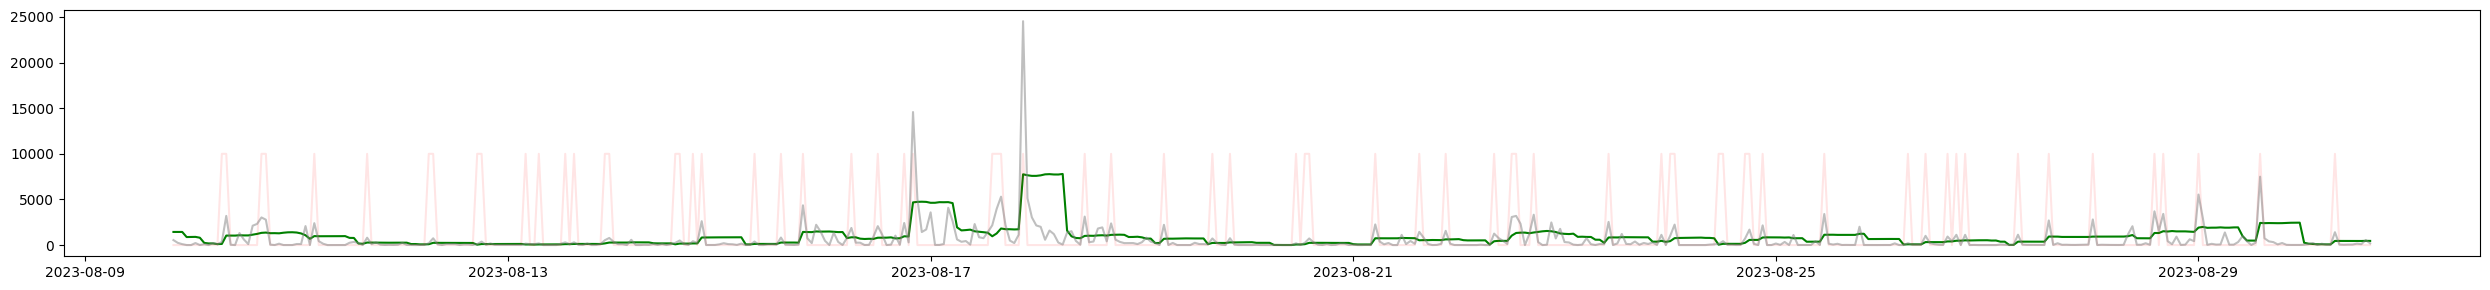

In [157]:
plt.figure(figsize=(25,3))

# plt.plot(df["std"], color="gray")
# plt.plot(df["std_1"], color="blue")
plt.plot(df["std_2"], color="green")
# plt.plot(df["avg_vol"], color="orange")
# plt.bar(df.index, df['volume'],color='gray', width=0.5, alpha=0.3)
df["x"]= df.volume > df["std_2"] * 2
df["xxx"] = df.x * 10000
# plt.plot(df.index,df.x, color = "blue", alpha=0.5)
plt.plot(df.index, df['xxx'], color='red', alpha=0.1)
plt.plot(df.index, df['volume'], color='gray', alpha=0.5)

plt.tight_layout() 
plt.show()

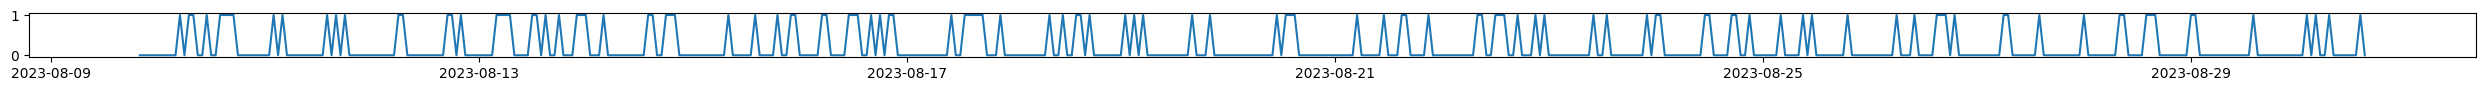

In [149]:
plt.figure(figsize=(25,1))
plt.plot(df["above_avg"])
plt.tight_layout() 
plt.show()

In [141]:
df[["volume", "std_2", "above_avg"]].tail(10)

,volume,std_2,above_avg
time,,,
2023-08-30 06:00:00,18.1,77.239727,False
2023-08-30 07:00:00,1409.1,455.405344,True
2023-08-30 08:00:00,63.6,453.167723,False
2023-08-30 09:00:00,40.0,451.837219,False
2023-08-30 10:00:00,57.2,450.952035,False
2023-08-30 11:00:00,60.1,452.445651,False
2023-08-30 12:00:00,158.1,452.701735,False
2023-08-30 13:00:00,101.3,448.794359,False
2023-08-30 14:00:00,553.2,461.966124,True


In [134]:
df['counter_bbm_cross_up'] = df.index.where(df.bbm_cross_up)
df['counter_bbm_cross_up'].fillna(method="ffill", inplace=True)

df['counter_bbu_slow_cross_down'] = df.index.where(df.bbu_slow_cross_down)
df['counter_bbu_slow_cross_down'].fillna(method="ffill", inplace=True)

df['date'] = pd.to_datetime(df.index)

df['delta_bbm_cross_up']            = ( df['date'].sub(df['counter_bbm_cross_up']).astype('timedelta64[s]').dt.total_seconds() ) +1
df['delta_bbu_slow_cross_down']     = ( df['date'].sub(df['counter_bbu_slow_cross_down']).astype('timedelta64[s]').dt.total_seconds() ) +1
df['bbm_cross_up_last']             = df['delta_bbm_cross_up'] < df['delta_bbu_slow_cross_down'].fillna(float('inf'))

# df.drop(['counter_bbm_cross_up', 'counter_bbu_slow_cross_down', 'date'], axis=1,inplace=True)


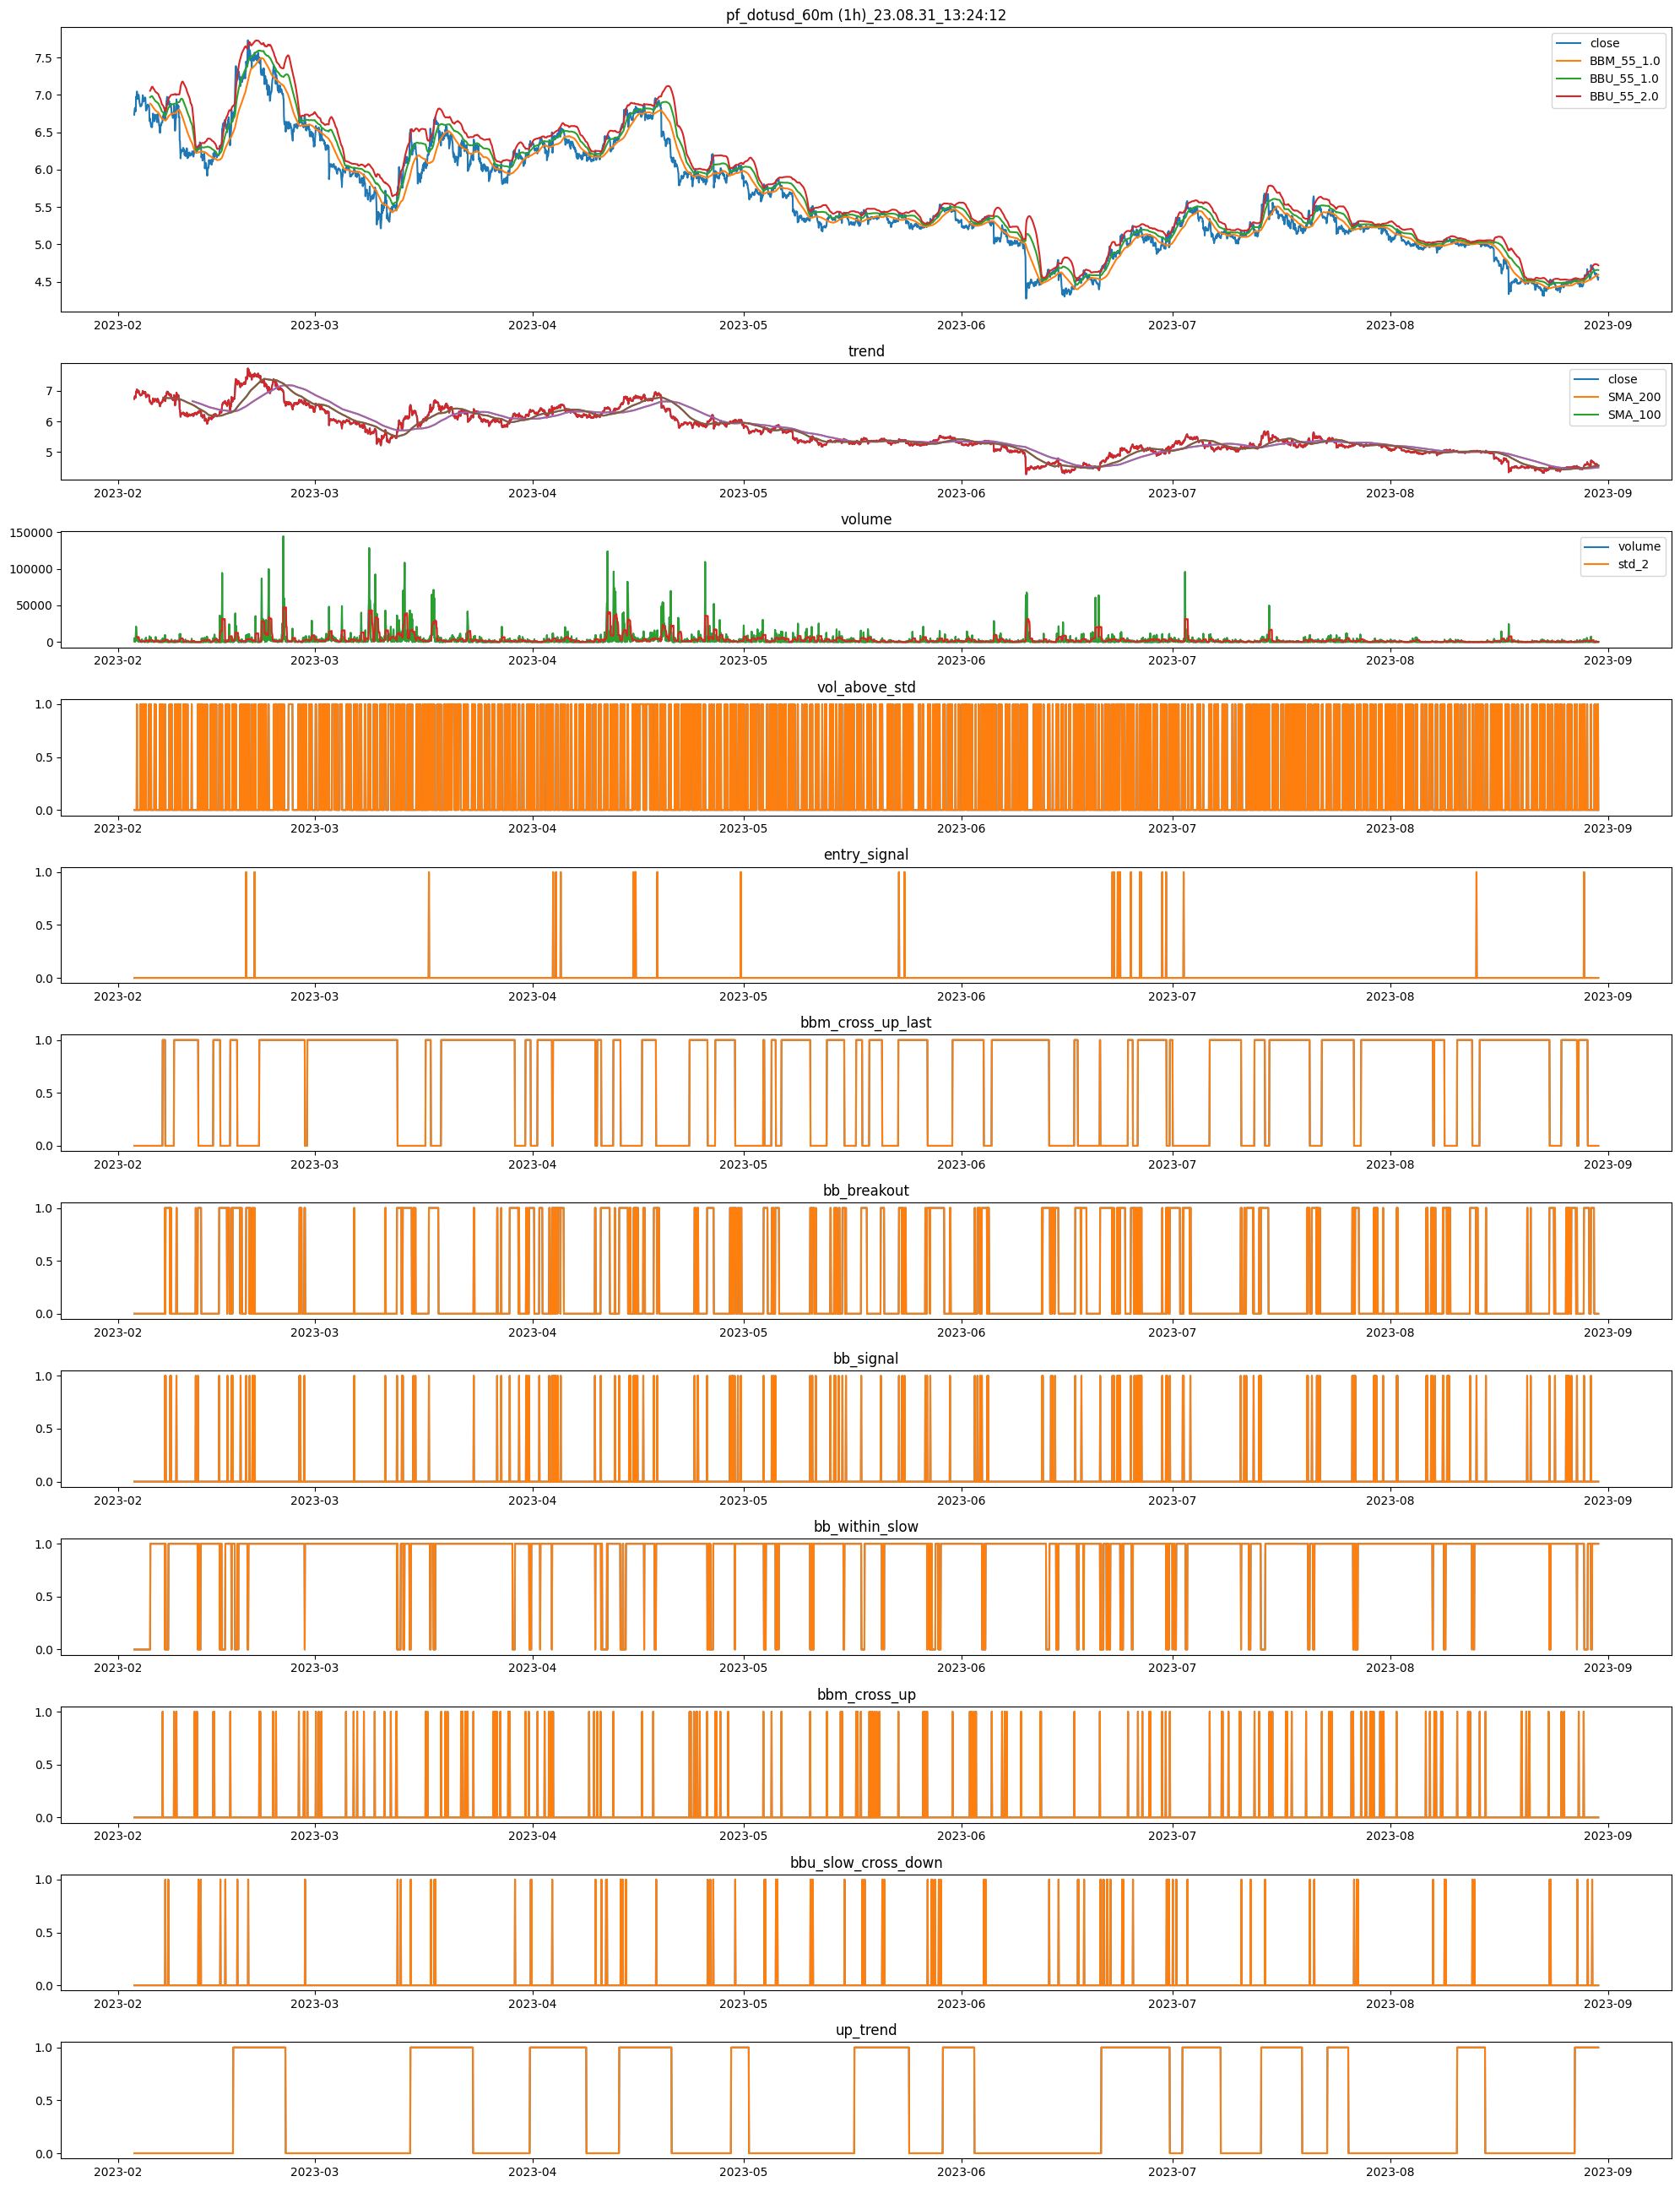

In [135]:

chart_data      = df[['close', bbm, bbu, bbu_slow]]
trend           = ('trend', df[['close', slowMa, fastMa]])
entry_signal    = ('entry_signal', df[['entry_signal']] )
bb_signal       = ('bb_signal', df[['bb_signal']] )
bb_breakout     = ('bb_breakout', df[['bb_breakout']] )
bb_within_slow  = ('bb_within_slow', df[['bb_within_slow']] )
up_trend        = ('up_trend', df[['up_trend']] )
bbm_cross_up            = ('bbm_cross_up', df[['bbm_cross_up']] )
bbu_slow_cross_down     = ('bbu_slow_cross_down', df[['bbu_slow_cross_down']] )
bbm_cross_up_last       = ('bbm_cross_up_last', df[['bbm_cross_up_last']] )
volume = ("volume", df[["volume", "std_2"]])
vol_above_std = ("vol_above_std", df["above_avg"])

signals         = [trend, volume, vol_above_std, entry_signal, bbm_cross_up_last, bb_breakout, bb_signal, bb_within_slow, bbm_cross_up, bbu_slow_cross_down, up_trend]
chart(pair, str(interval), chart_data, signals)


SO

Regla: 
+ Vera fyrir neðan SO threshold (%) ('so_price_deviation') á síðasta kauptilboði ('last_order_price')
+ RSI er að krossa upp yfir threshold ('cross_up_trigger')

In [9]:
df = df_org.copy()
last_order_price = 4.955
position_avg_price = last_order_price

# Settings
so_price_deviation  = 1.
rsi_length          = 14
cross_up_trigger    = 50.

rsi_col_name = f"RSI_{rsi_length}"

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[ {
        "close":    'close',
        "kind":     'rsi', 
        "length":   rsi_length
    }]
)
df.ta.strategy(strategy)
df['position_avg_price'] = position_avg_price
df['last_order_price'] = last_order_price

df["rsi_cross_up"] = (df[rsi_col_name] > cross_up_trigger) & (df[rsi_col_name].shift() < cross_up_trigger)

soThreshold = last_order_price * (1 - (so_price_deviation / 100) )
df['so_threshold'] = soThreshold

df['RSI_50'] = 50.
df['cross_up_trigger'] = cross_up_trigger
df['so_price_below_threshold'] = df['close'] < df['so_threshold']
df['so_signal'] = (df['so_price_below_threshold'] == True) & (df['rsi_cross_up'] == True)

# df.tail()


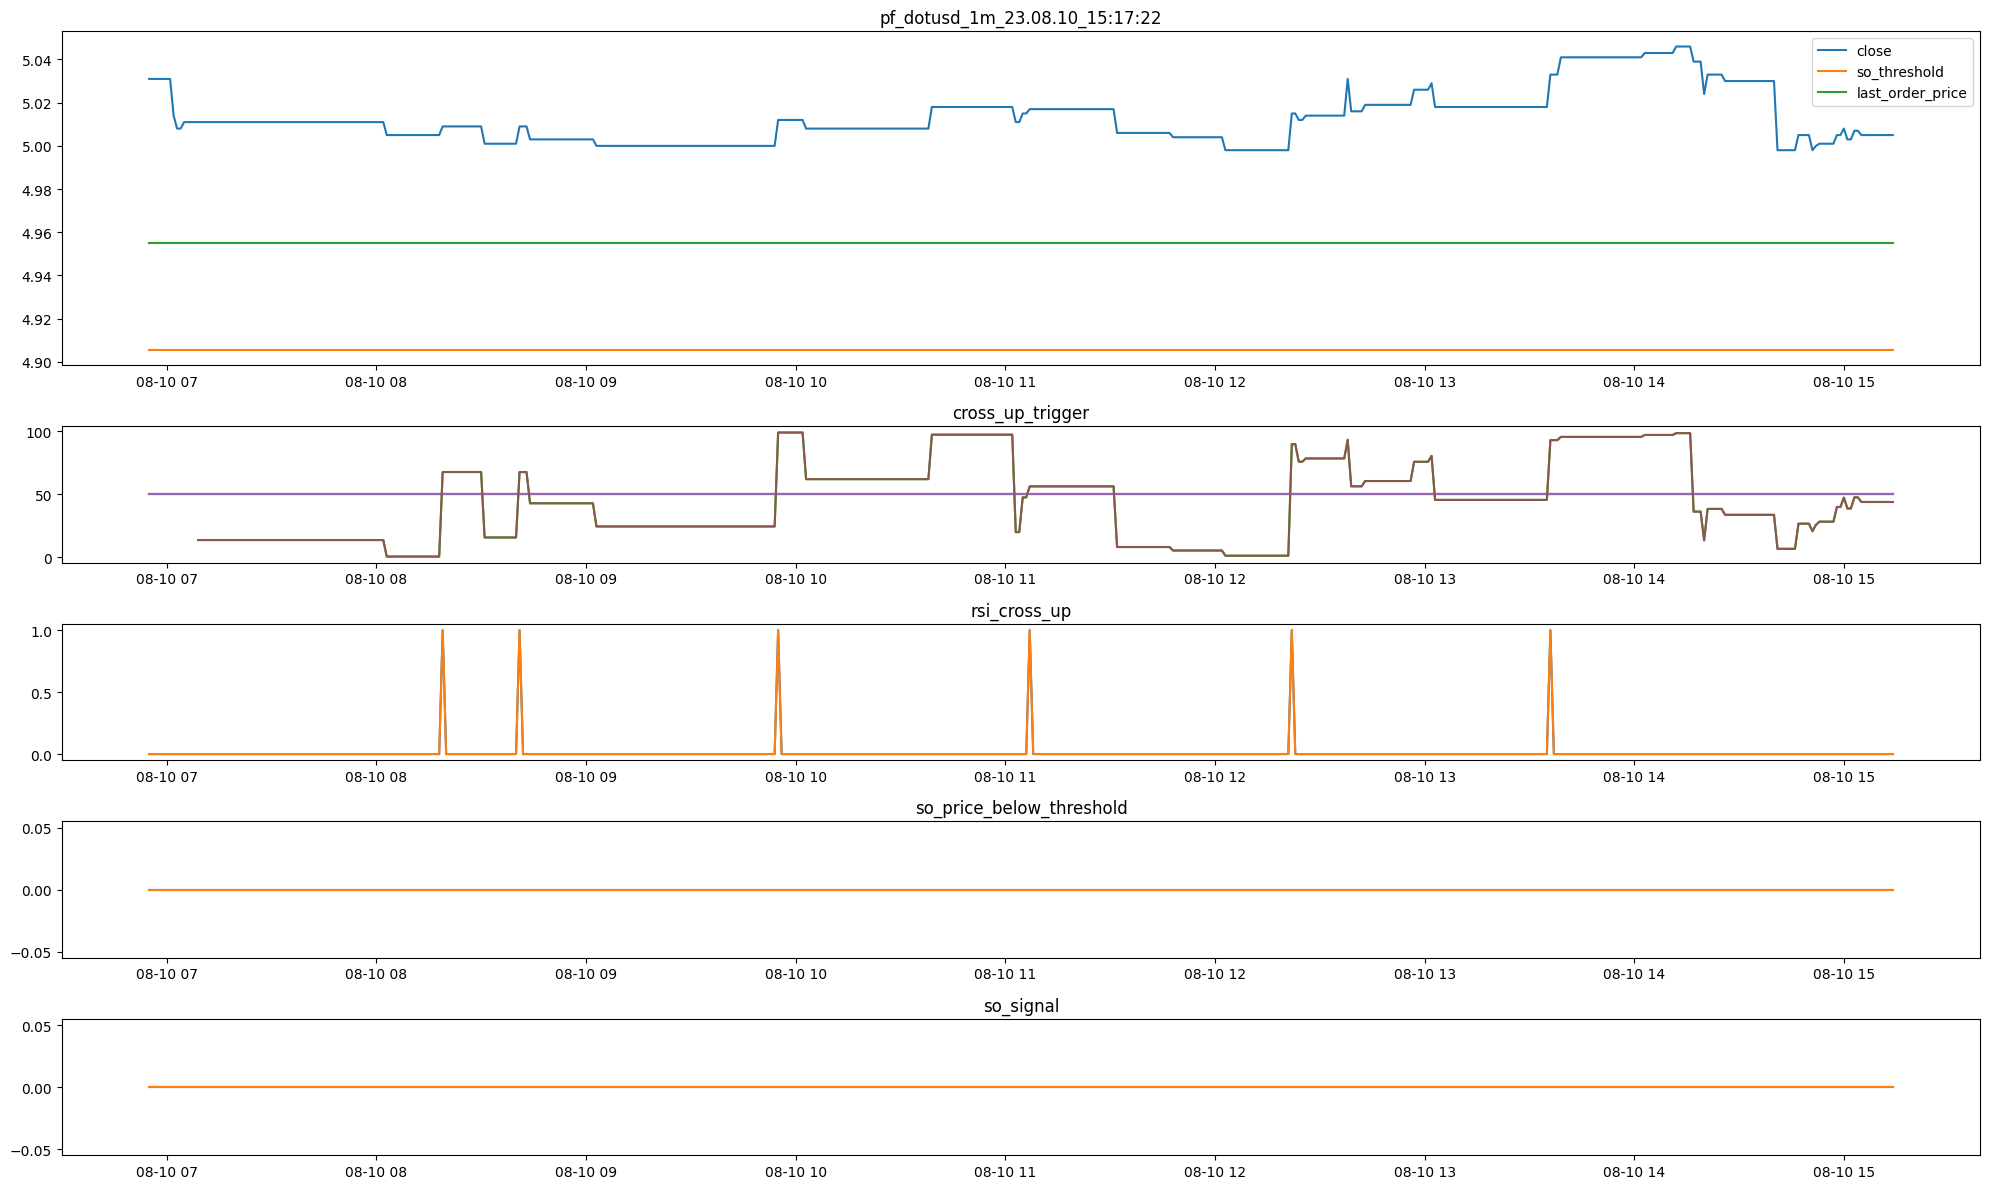

In [10]:
chart_data                  = df[['close', 'so_threshold', 'last_order_price']]
rsi_data                    = ('cross_up_trigger', df[['RSI_50', 'cross_up_trigger', rsi_col_name]])
so_signal                   = ('so_signal', df[['so_signal']])
so_price_below_threshold    = ('so_price_below_threshold', df[['so_price_below_threshold']])
rsi_cross_up_d              = ('rsi_cross_up', df[['rsi_cross_up']])

s = [rsi_data, rsi_cross_up_d, so_price_below_threshold, so_signal]
chart(pair, str(interval), chart_data, s)


TP

Regla: 
+ Þarf að vera ofar en TP target ('take_profit_price')  
+ RSI crossar niður fyrir tiltekið level ('tp_rsi_cross_down_trigger')


In [499]:
df = df_org.copy()

last_order_price = 4.955
position_avg_price = last_order_price

# Settings
target_profit               = 1.
tp_rsi_cross_down_trigger   = 55.
rsi_length                  = 14

rsi_col_name = f"RSI_{rsi_length}"

strategy = ta.Strategy(
    name="strategy_BBbreakout",
    ta=[ {
        "close":    'close',
        "kind":     'rsi', 
        "length":   rsi_length
    }]
)
df.ta.strategy(strategy)


take_profit_price = position_avg_price + (position_avg_price * ((target_profit) / 100))

df['tp_rsi_cross_down_trigger'] = tp_rsi_cross_down_trigger
df['take_profit_price']         = take_profit_price

df["rsi_tp_cross_down"] = (df[rsi_col_name] < tp_rsi_cross_down_trigger) & (df[rsi_col_name].shift() > tp_rsi_cross_down_trigger)
df['above_tp_price']    = df['close'] > df['take_profit_price'].shift()
df['tp_trigger']        = df['rsi_tp_cross_down'] & df['above_tp_price']

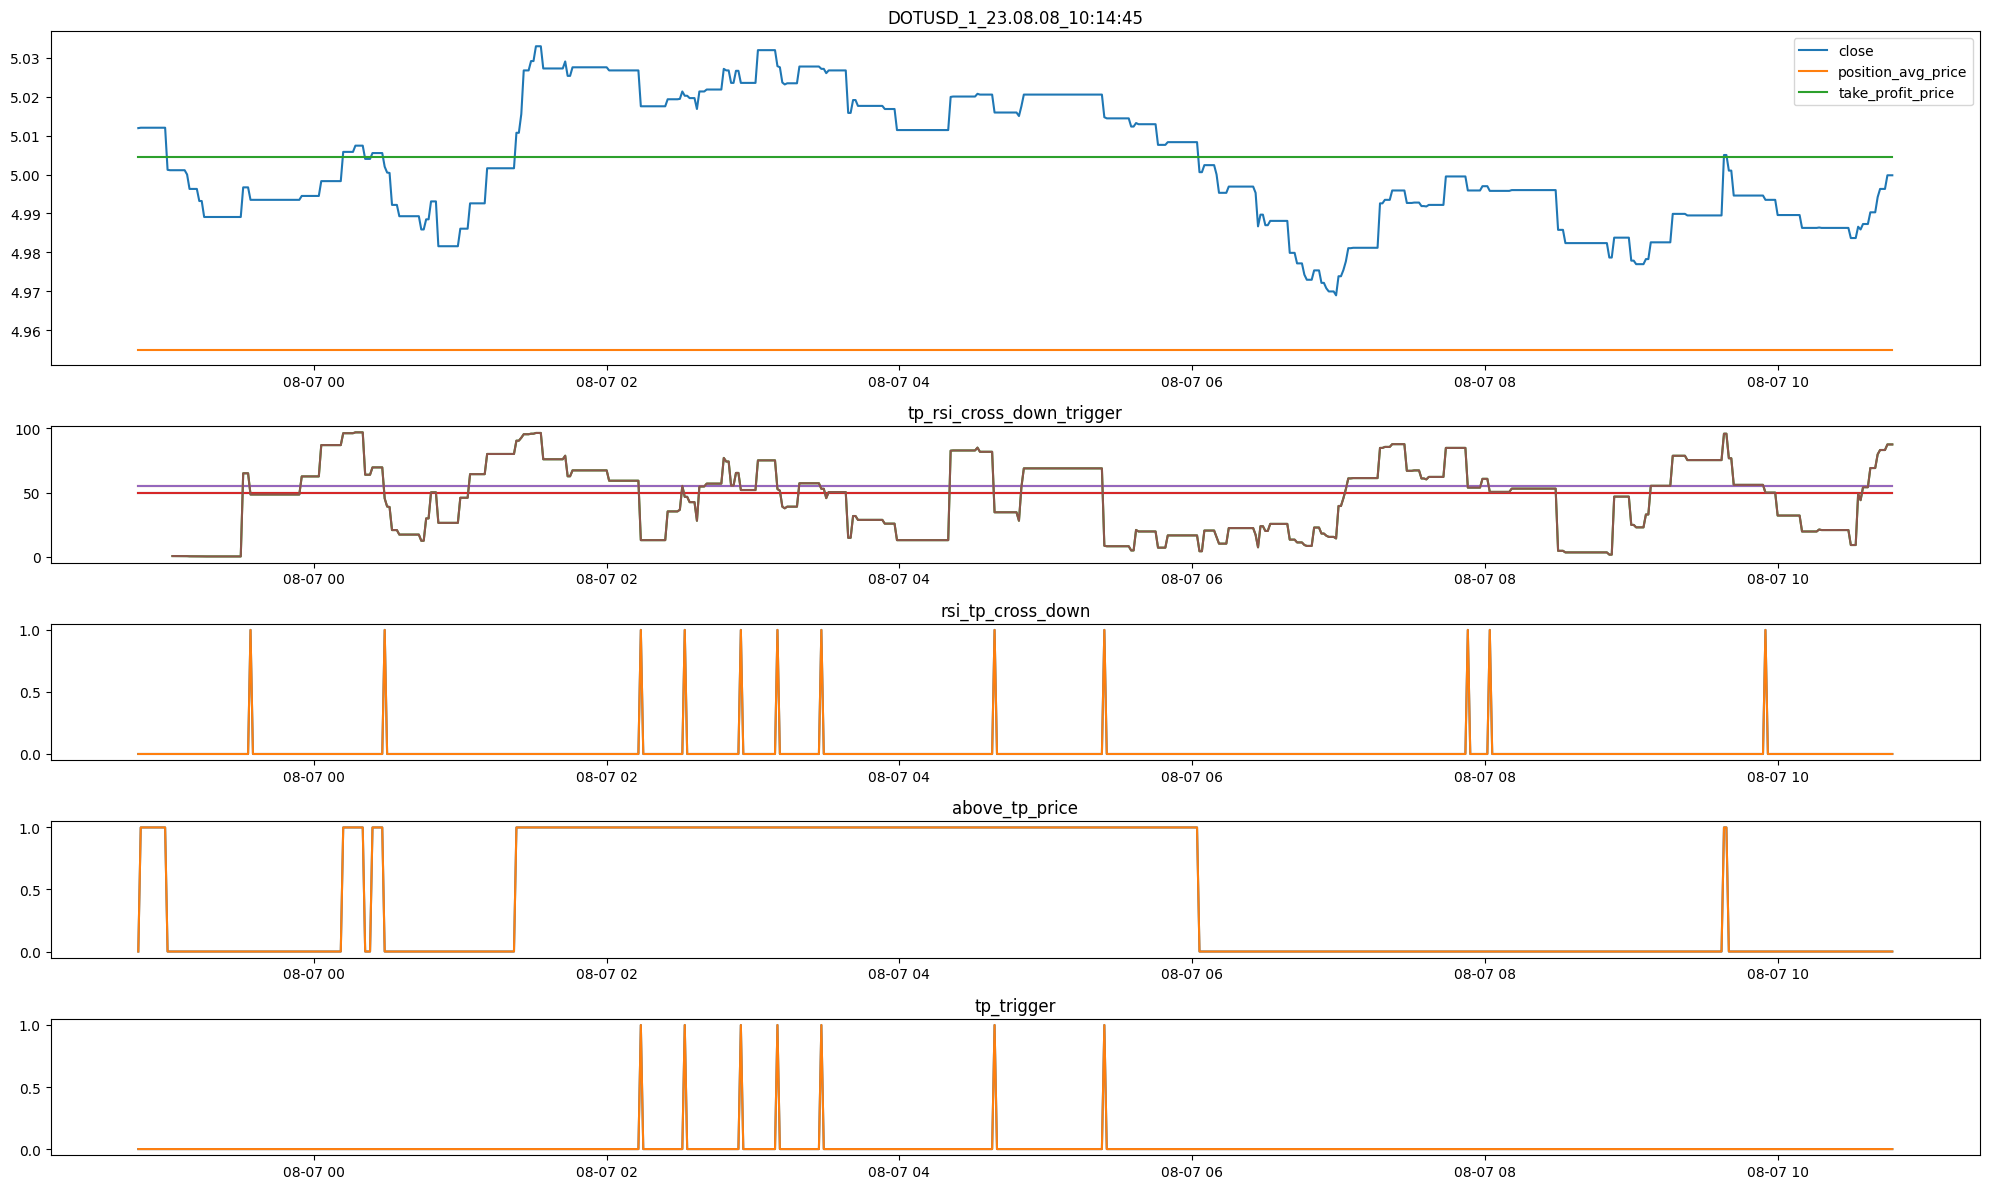

In [500]:
df['RSI_50'] = 50.
df['position_avg_price'] = position_avg_price
df['last_order_price'] = last_order_price

chart_data                  = df[['close', 'position_avg_price', 'take_profit_price']]
tp_rsi_cross_down_trigger   = ('tp_rsi_cross_down_trigger', df[['RSI_50', 'tp_rsi_cross_down_trigger', rsi_col_name]])
tp_trigger                  = ('tp_trigger', df[['tp_trigger']])
rsi_tp_cross_down           = ('rsi_tp_cross_down', df[['rsi_tp_cross_down']])
above_tp_price              = ('above_tp_price', df[['above_tp_price']])
s = [tp_rsi_cross_down_trigger, rsi_tp_cross_down, above_tp_price, tp_trigger]
chart(pair, str(interval), chart_data, s)

In [13]:
df = df.copy()

df.tail()


,open,high,low,close,volume,BBL_55_1.0,BBM_55_1.0,BBU_55_1.0,BBB_55_1.0,BBP_55_1.0,...,BBP_55_2.0,SMA_100,SMA_200,up_trend,ema_cross_up,ema_cross_down,bb_breakout,bb_within_slow,bb_signal,entry_signal
time,,,,,,,,,,,,,,,,,,,,,
2023-08-10 15:10:00,5.005,5.005,5.005,5.005,0.0,5.000882,5.016018,5.031155,0.603520,0.136035,...,0.318018,5.02625,5.019405,True,False,False,False,True,False,False
2023-08-10 15:11:00,5.005,5.005,5.005,5.005,0.0,5.000630,5.015273,5.029916,0.583935,0.149227,...,0.324613,5.02612,5.019410,True,False,False,False,True,False,False
2023-08-10 15:12:00,5.005,5.005,5.005,5.005,0.0,5.000312,5.014655,5.028997,0.572037,0.163437,...,0.331718,5.02599,5.019415,True,False,False,False,True,False,False
2023-08-10 15:13:00,5.005,5.005,5.005,5.005,0.0,5.000027,5.014036,5.028045,0.558793,0.177481,...,0.338741,5.02586,5.019420,True,False,False,False,True,False,False
2023-08-10 15:14:00,5.005,5.005,5.005,5.005,0.0,4.999779,5.013418,5.027057,0.544104,0.191395,...,0.345698,5.02573,5.019425,True,False,False,False,True,False,False
